[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/bsipocz/astroML-notebooks/notebooks?filepath=chapter6/Figure6-11.ipynb)

# Extreme Deconvolution

## Introduction
**Extreme deconvolution (XD)** combines Baysian extimation and Gaussian model in the algorithm to correct data with measurement errors.  
The algorithm basically assumes an observed value ${x_i}$, true value ${v_i}$, and noise ${\epsilon}$ 
have the following relationship:

$${x_i} = {R_i}{v_i}+{\epsilon_i}$$  

where ${R_i}$ is a projection matrix. After we compute this matrix using assumed Gaussian model, we are able to convert
noisy data back to true data.  
  
In section A, we plot four scattered point distribution graphs to show
how XD corrects noisy unsupervised data.  
("Unsupervised" here means no additional information is given on the data).  

In section B, we will apply real stellar data sample and see how XD works in correcting data distribution. Again we will plot four graphs in comparison.

## Import Data and Functions
The functions we need are in astroML. XDGMM is the main function we call to perform extreme deconvolution.  
The data we use to in this demostration is from the Stripe 82 Standard Star Catalog (high SNR) and single epoch observations (low SNR).  
More information about data used is in references.

In [0]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.stats import sigmaG


## A. XD on a generated dataset
In the first section, we will explore how XD works using randomly generated data set.

### 1. Generate true data
We first generate a distribution of "true data" using radomized numbers.
We will plot this data set as a reference to compare with the model derived from estimation with XD.  
Users can change sample size (N) to experiment the effectiveness of this method: Bigger sample size gives more information about the data set and is easier to converge, however it takes longer time to run in the method. The method may fail to converge due to small sample size.

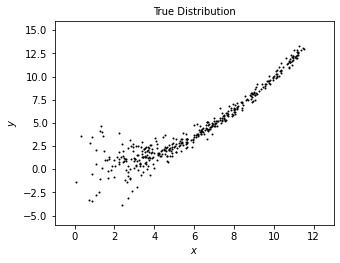

In [0]:
# Sample the dataset. 
# Here we use sample size = 400 in the example, 
# which converges in shorter time, and gives reasonable result.
N = 400
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# define a function to plot all distributions in the same format
def plot_distribution(text, sample_x, sample_y):
    plt.figure(figsize=(5, 3.75))
    plt.scatter(sample_x, sample_y, s=4,lw=0,c='k')
    plt.xlim(-1, 13)
    plt.ylim(-6, 16)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(text,fontsize=10)

# plot true distribution
plot_distribution('True Distribution', x_true, y_true)

plt.show()

### 2. Generate noisy data
We add some radom noisy onto the true data to model what we may observe from true distribution.

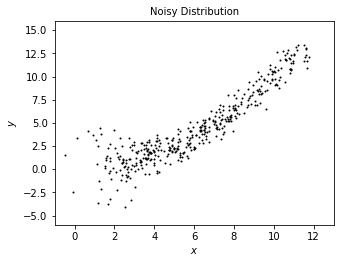

In [0]:
# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# plot noisy distribution
plot_distribution('Noisy Distribution', x, y)

### 3. Compute extreme deconvolution (XD)
The code below computes the result.
In the XDGMM method, *n_components* (integer) defines the number of Gaussian components to fit to the data.  
*max_iter* (integer) defines number of EM iterations to perform (default as 100). Larger iteration number generally contributes better approximation to the true data, but takes longer time to execute.   
This cell is expected to execute in a bit long time around 1 minute.

In [0]:
# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

clf = XDGMM(n_components=10, max_iter=200)

clf.fit(X, Xerr)
sample = clf.sample(N)

### 4. Plot the result from XD
We use scattered point to show the result of noisy data from XD correction. The plot shows a less scattered distribution 
than noisy data and even than true data, which better portraits a "underlying distribution."

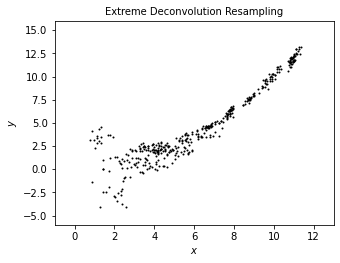

In [0]:
# plot noisy distribution
plot_distribution('Extreme Deconvolution Resampling', sample[:, 0], sample[:, 1])

### 5. Use subplots to show clear comparison
We plot true distribution (top left), noisy distribution (top right), and resampled distribution from XD (bottom left)
together to show a clear comparison for the effectiveness of this method in modeling.  
In addition, we add a clustered representation of the distribution (bottom right) to show the use in locating clusters with
XD method.

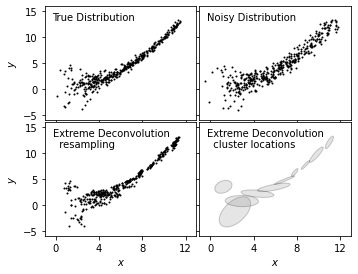

In [0]:
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

## B. XD on real star sample
In this section, we use a set of standard stars from S82 (high SNR), and a set of noisy single epoch of stars (low SNR). We will perform XD on the noisy data and see how it resamples the data into clusters.

### 1. Perform extinction correction on noisy sample
First, we fix the star's true color from dust extinction in noisy data sample. We apply extinction correction curve defined as 
$C_{\lambda} \equiv \frac{A_{\lambda}}{A}$, where the value of $C_{\lambda}$ for each band of S82 is from [Berry et al 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...757..166B/abstract).

In [0]:
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985 multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

### 2. Perform extinction correction on standard sample
Next, we stack the S82 star set and perform the same extinction correction on the data. 

In [0]:
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

### 3. Cross-match two data sets
We use cross-match to match the noisy sample to standard sample, and make two sets comparable.

In [0]:
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)

number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)


### 4. Define W matrix and calculate covariance

In [0]:
# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

### 5. Plot two raw data sets
We choose ten percent of the points in each data sets to plot in comparison. As we can see from the result, before XD, the sigle epoch (right) has more noise than standard stars (left).

In [0]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(10, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(121)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')
ax1.set_ylabel('$r-i$')

ax2 = fig.add_subplot(122)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

titles = ["Standard Stars", "Single Epoch"]
ax = [ax1, ax2]

for i in range(2):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    ax[i].set_xlabel('$g-r$')

NameError: ignored

### 6. Calculate XD value
We define compute_XD and save the result to pickle file. This cell is estimated to take a long running time (more than 20 minutes).

In [0]:
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf

clf = compute_XD(12)

### 7. Plot results in comparison
Here we plot the result of noisy data after XD in scattered points (lower left), with a cluster location estimation in ellipses, in comparison with the original two data sets.  
After XD resampling, the resampled data distributes less scattered than the original noisy data. It also shows a better clustered pattern than the standard star distribution.

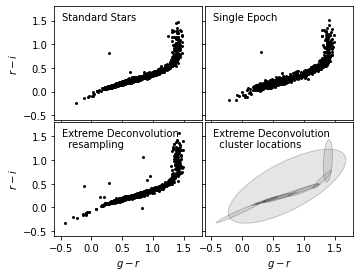

In [0]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')

### 8. Plot width of Locus
We plot the widths of standard stars, single epoch and XD resampled result in one graph.   
On the x-axis shows the width of locus, also called w color, defined as 
$w = -0.227g + 0.792r - 0.567i + 0.05$.  
$\sigma_{G}$ of the Gaussian distribution fit is the smallest in XD resampled result. This shows the effectiveness of correcting and clustering noisy data.

In [0]:
# Second figure: the width of the locus
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')